In [2]:
pip install opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 14.8 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105789 sha256=93f0d2d8488908605ae9f90f723dfc9025daad4cbfa7a109a0adc72ac2429a51
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: certifi
    Found existing installation: certifi 2020.6.20
    Uninstalling certifi-2020.6.20:
      Successfully uninstalled certifi-2020.6.20
Note: you may need to restart the kernel to use updated packages.


In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  shruthi2905


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces


100%|██████████| 3.75G/3.75G [00:42<00:00, 94.6MB/s]


In [19]:
import tensorflow as tf

# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs found:", gpus)
    for gpu in gpus:
        # Print GPU details
        print(f"GPU {gpu.name}: {gpu.device_type}")
else:
    print("No GPU found.")

GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU /physical_device:GPU:0: GPU


2024-12-10 15:06:19.193494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-10 15:06:19.194420: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-10 15:06:19.194618: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [20]:
import os
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet121, ResNet50 ,VGG16
from tensorflow.keras.models import Model
import shutil

In [21]:
class Data:
    def _subset_directory(self, input_dir, max_images_per_class=50):
        subset_dir = input_dir + '_subset'
        if os.path.exists(subset_dir):
            shutil.rmtree(subset_dir)
        os.makedirs(subset_dir, exist_ok=True)
        for class_name in os.listdir(input_dir):
            class_path = os.path.join(input_dir, class_name)
            subset_class_path = os.path.join(subset_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            os.makedirs(subset_class_path, exist_ok=True)
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            subset_files = image_files[:max_images_per_class]
            for img_file in subset_files:
                src_path = os.path.join(class_path, img_file)
                dst_path = os.path.join(subset_class_path, img_file)
                shutil.copy(src_path, dst_path)
        return subset_dir


In [22]:
obj=Data()
train_dir = obj._subset_directory('140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train',max_images_per_class=5000)
val_dir = obj._subset_directory('140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid',max_images_per_class=5000)
test_dir = obj._subset_directory('140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test',max_images_per_class=5000)

In [23]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(val_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [24]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)
target_size = (256,256)
batch_size = 32  # Update this according to your batch size

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)


test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure test data is not shuffled
)

Found 10000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [25]:
# Verify class distribution
print("Training class distribution:", train_generator.class_indices)
print("Validation class distribution:", val_generator.class_indices)

Training class distribution: {'fake': 0, 'real': 1}
Validation class distribution: {'fake': 0, 'real': 1}


In [26]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

2024-12-10 15:10:08.666209: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-10 15:10:08.666565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-10 15:10:08.666776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

58889256/58889256 [==============================] - 1s 0us/step


In [27]:
# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-3:]:  # Unfreeze the last 4 layers (customize this as needed)
    layer.trainable = True

# Recompile the model after making layers trainable
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # You can reduce the learning rate further if needed
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [28]:
# Define callbacks
callbacks = [
    #ModelCheckpoint('vgg16_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]

In [29]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    callbacks=callbacks
)

Epoch 1/4


2024-12-10 15:10:27.175958: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-12-10 15:10:35.858610: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f30680c7bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-10 15:10:35.858916: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 4000, Compute Capability 7.5
2024-12-10 15:10:35.896687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733843436.086755    1905 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-12-10 15:10:40.653523: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.20GiB with freed_by_count=0. The caller indicates that thi

313/313 [==============================] - 211s 582ms/step - loss: 0.5363 - accuracy: 0.7291 - val_loss: 0.3973 - val_accuracy: 0.8239 - lr: 1.0000e-05
Epoch 2/4
313/313 [==============================] - 171s 545ms/step - loss: 0.3477 - accuracy: 0.8460 - val_loss: 0.3632 - val_accuracy: 0.8349 - lr: 1.0000e-05
Epoch 3/4
313/313 [==============================] - 186s 593ms/step - loss: 0.2316 - accuracy: 0.9046 - val_loss: 0.2122 - val_accuracy: 0.9198 - lr: 1.0000e-05
Epoch 4/4
313/313 [==============================] - 171s 546ms/step - loss: 0.1594 - accuracy: 0.9397 - val_loss: 0.1866 - val_accuracy: 0.9257 - lr: 1.0000e-05


In [30]:
test_metrics = model.evaluate(test_generator)
print("Test metrics:", test_metrics[1])

313/313 [==============================] - 53s 169ms/step - loss: 0.1840 - accuracy: 0.9281
Test metrics: 0.9280999898910522


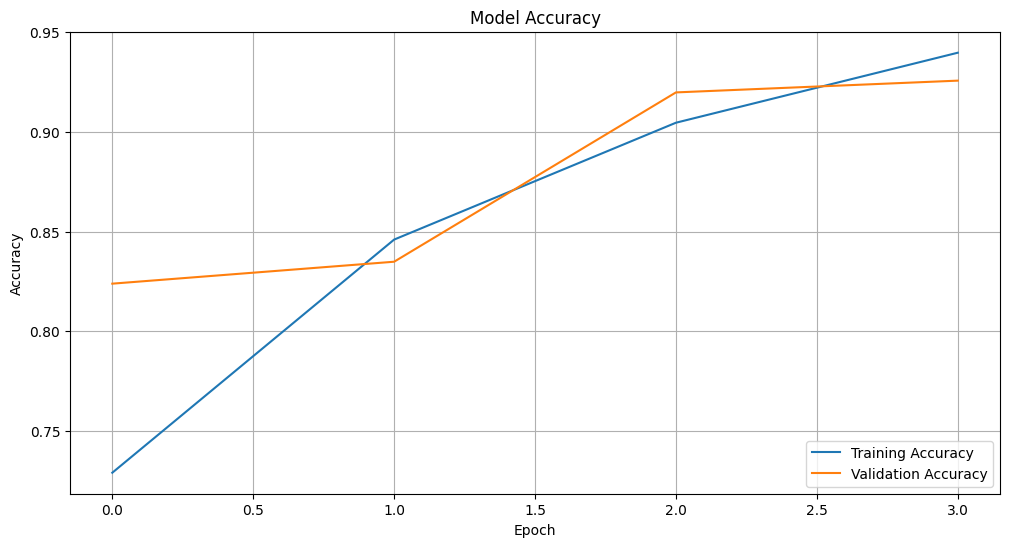

In [31]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

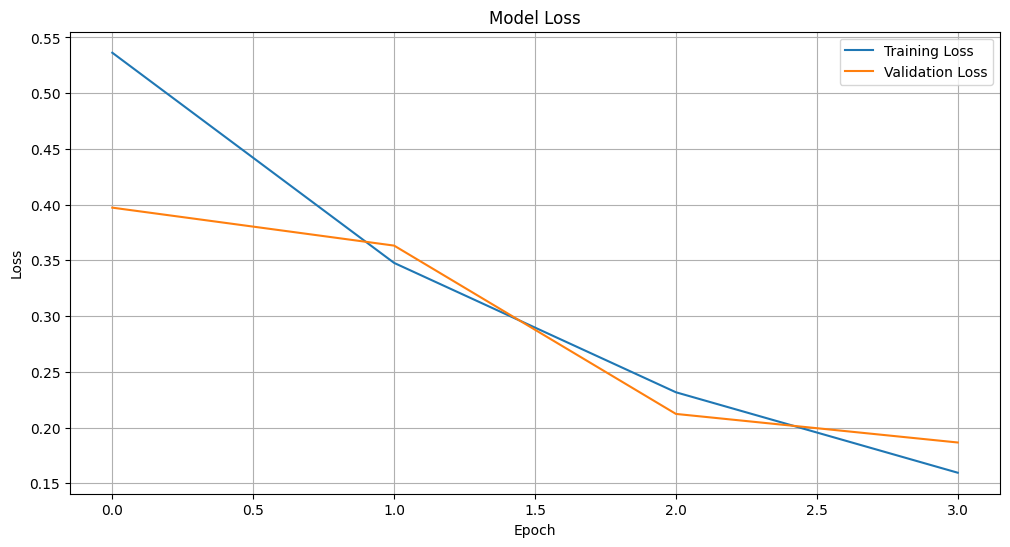

In [32]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Generate predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# The model output is the probability of the image being real
# Convert probabilities to percentage
predicted_percentages = predictions * 100

# Convert to predicted classes with a threshold of 50%
predicted_classes = np.where(predicted_percentages > 50, 1, 0)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
# 3. Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 4. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 808ms/step


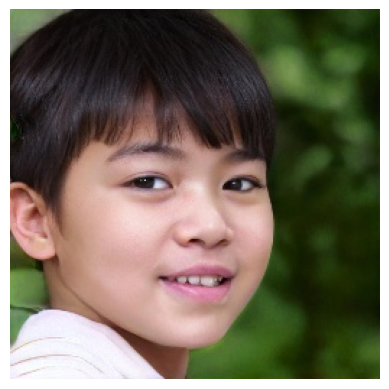

The model predicts this image is 'real' with a confidence of 3.06%.
The model predicts this image is 'fake' with a confidence of 96.94%.


In [33]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    # Load image
    img = image.load_img(img_path, target_size=target_size)

    # Convert image to array
    img_array = image.img_to_array(img)

    # Rescale the image
    img_array = img_array / 255.0

    # Expand dimensions to match the input shape
    img_array = np.expand_dims(img_array, axis=0)

    return img, img_array

img_path = '140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/00W5NPIX4S.jpg'
target_size = (256, 256)  # Make sure this matches your model's input size

# Load and preprocess the image
img, img_array = load_and_preprocess_image(img_path, target_size)

# Make a prediction
prediction = model.predict(img_array)

# Get the percentage for both classes
real_confidence = prediction[0][0] * 100
fake_confidence = (1 - prediction[0][0]) * 100

plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the results
print(f"The model predicts this image is 'real' with a confidence of {real_confidence:.2f}%.")
print(f"The model predicts this image is 'fake' with a confidence of {fake_confidence:.2f}%.")